In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s3e22/sample_submission.csv
/kaggle/input/playground-series-s3e22/train.csv
/kaggle/input/playground-series-s3e22/test.csv


In [2]:
train_horses=pd.read_csv('/kaggle/input/playground-series-s3e22/train.csv')
test_horses=pd.read_csv('/kaggle/input/playground-series-s3e22/test.csv')

In [3]:
train_horses.head()

id surgery    age  hospital_number  rectal_temp  pulse  respiratory_rate  \
0   0     yes  adult           530001         38.1  132.0              24.0   
1   1     yes  adult           533836         37.5   88.0              12.0   
2   2     yes  adult           529812         38.3  120.0              28.0   
3   3     yes  adult          5262541         37.1   72.0              30.0   
4   4      no  adult          5299629         38.0   52.0              48.0   

  temp_of_extremities peripheral_pulse mucous_membrane  ...  \
0                cool          reduced   dark_cyanotic  ...   
1                cool           normal   pale_cyanotic  ...   
2                cool          reduced       pale_pink  ...   
3                cold          reduced       pale_pink  ...   
4              normal           normal     normal_pink  ...   

  packed_cell_volume total_protein abdomo_appearance abdomo_protein  \
0               57.0           8.5     serosanguious            3.4   
1               33.0          64.0     serosanguious            2.0   
2               37.0           6.4     serosanguious            3.4   
3               53.0           7.0            cloudy            3.9   
4               47.0           7.3            cloudy            2.6   

  surgical_lesion lesion_1  lesion_2 lesion_3 cp_data     outcome  
0             yes     2209         0        0      no        died  
1             yes     2208         0        0      no  euthanized  
2             yes     5124         0        0      no       lived  
3             yes     2208         0        0     yes       lived  
4              no        0         0        0     yes       lived  

[5 rows x 29 columns]

In [4]:
train_horses.drop(columns=['id'], inplace=True)

In [5]:
test_horses.head()

id surgery    age  hospital_number  rectal_temp  pulse  respiratory_rate  \
0  1235      no  adult           534053         38.6   40.0              20.0   
1  1236     yes  adult           528469         38.2  112.0              48.0   
2  1237     yes  adult           528178         37.7   66.0              12.0   
3  1238      no  adult           534784         37.1   88.0              20.0   
4  1239     yes  adult           529840         38.3   50.0              12.0   

  temp_of_extremities peripheral_pulse mucous_membrane  ...        abdomen  \
0              normal           normal     normal_pink  ...  distend_small   
1                cool          reduced     bright_pink  ...  distend_small   
2                cool           normal      bright_red  ...  distend_small   
3                cool          reduced   pale_cyanotic  ...  distend_large   
4                 NaN           normal     bright_pink  ...  distend_small   

  packed_cell_volume total_protein abdomo_appearance abdomo_protein  \
0               42.0           7.5             clear            2.3   
1               44.0           6.0     serosanguious            2.6   
2               31.5           6.0            cloudy            1.6   
3               75.0          81.0               NaN            1.0   
4               37.0           6.8            cloudy            2.6   

  surgical_lesion  lesion_1 lesion_2 lesion_3  cp_data  
0              no         0        0        0       no  
1              no      2208        0        0      yes  
2             yes      2205        0        0      yes  
3             yes      1400        0        0       no  
4             yes      2208        0        0      yes  

[5 rows x 28 columns]

In [6]:
test_horses.drop(columns=['id'], inplace=True)

### Function to score dataset

In [7]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import cross_val_predict

from xgboost import XGBClassifier
def score_dataset(X, y, model=XGBClassifier()):
    # Label encoding for categoricals
    for colname in X.select_dtypes(["category", "object"]):
        X[colname], _ = X[colname].factorize()
    # Define a custom scoring function for micro-averaged F1-score
    predicted = cross_val_predict(model, X, y, cv=5)
    # Calculate the micro-averaged F1 score
    micro_f1_score = f1_score(y, predicted, average='micro')
    
    return micro_f1_score

#### Quick Preprocessing

fix misplaced values in specific columns

In [8]:
# change 3 to more_3_sec
train_horses['capillary_refill_time'].replace({'3': 'more_3_sec'}, inplace=True)
# convert slight and moderate to mild pain category
train_horses['pain'].replace({'slight': 'mild_pain'}, inplace=True)
train_horses['pain'].replace({'moderate': 'mild_pain'}, inplace=True)
# clean below 3 columns
train_horses['peristalsis'].replace({'distend_small': np.nan}, inplace=True)
train_horses['nasogastric_reflux'].replace({'slight': np.nan}, inplace=True)
train_horses['rectal_exam_feces'].replace({'serosanguious': np.nan}, inplace=True)

applying on test

In [9]:
# change 3 to more_3_sec
test_horses['capillary_refill_time'].replace({'3': 'more_3_sec'}, inplace=True)
# convert slight and moderate to mild pain category
test_horses['pain'].replace({'slight': 'mild_pain'}, inplace=True)
test_horses['pain'].replace({'moderate': 'mild_pain'}, inplace=True)
# clean below 3 columns
test_horses['peristalsis'].replace({'distend_small': np.nan}, inplace=True)
test_horses['nasogastric_reflux'].replace({'slight': np.nan}, inplace=True)
test_horses['rectal_exam_feces'].replace({'serosanguious': np.nan}, inplace=True)

change datatype of surgery, surgical_lesion, cp_data to boolean

In [10]:
train_horses['surgery']=train_horses['surgery'].astype(bool)
train_horses['surgical_lesion']=train_horses['surgical_lesion'].astype(bool)
train_horses['cp_data']=train_horses['cp_data'].astype(bool)

In [11]:
test_horses['surgery']=test_horses['surgery'].astype(bool)
test_horses['surgical_lesion']=test_horses['surgical_lesion'].astype(bool)
test_horses['cp_data']=test_horses['cp_data'].astype(bool)

In [12]:
train_horses.dtypes

surgery                     bool
age                       object
hospital_number            int64
rectal_temp              float64
pulse                    float64
respiratory_rate         float64
temp_of_extremities       object
peripheral_pulse          object
mucous_membrane           object
capillary_refill_time     object
pain                      object
peristalsis               object
abdominal_distention      object
nasogastric_tube          object
nasogastric_reflux        object
nasogastric_reflux_ph    float64
rectal_exam_feces         object
abdomen                   object
packed_cell_volume       float64
total_protein            float64
abdomo_appearance         object
abdomo_protein           float64
surgical_lesion             bool
lesion_1                   int64
lesion_2                   int64
lesion_3                   int64
cp_data                     bool
outcome                   object
dtype: object

In [13]:
missing_values=train_horses.isnull().sum()

In [14]:
missing_val=test_horses.isnull().sum()

In [15]:
missing_percentages = (missing_values / len(train_horses)) * 100
missing_data = pd.DataFrame({'Column_Name': train_horses.columns, 'Missing_Percentage': missing_percentages})
missing_data = missing_data.sort_values(by='Missing_Percentage', ascending=False)
print(missing_data)


                                 Column_Name  Missing_Percentage
abdomen                              abdomen           17.246964
rectal_exam_feces          rectal_exam_feces           15.465587
nasogastric_tube            nasogastric_tube            6.477733
peripheral_pulse            peripheral_pulse            4.858300
abdomo_appearance          abdomo_appearance            3.886640
pain                                    pain            3.562753
temp_of_extremities      temp_of_extremities            3.157895
abdominal_distention    abdominal_distention            1.862348
nasogastric_reflux        nasogastric_reflux            1.781377
mucous_membrane              mucous_membrane            1.700405
peristalsis                      peristalsis            1.700405
capillary_refill_time  capillary_refill_time            0.485830
total_protein                  total_protein            0.000000
lesion_1                            lesion_1            0.000000
lesion_2                 

In [16]:
# how many total missing values do we have?
total_cells = np.product(train_horses.shape)
total_missing = missing_values.sum()

# percent of data that is missing
percent_missing = (total_missing/total_cells) * 100
print(percent_missing)

2.220936957779063


<Axes: >

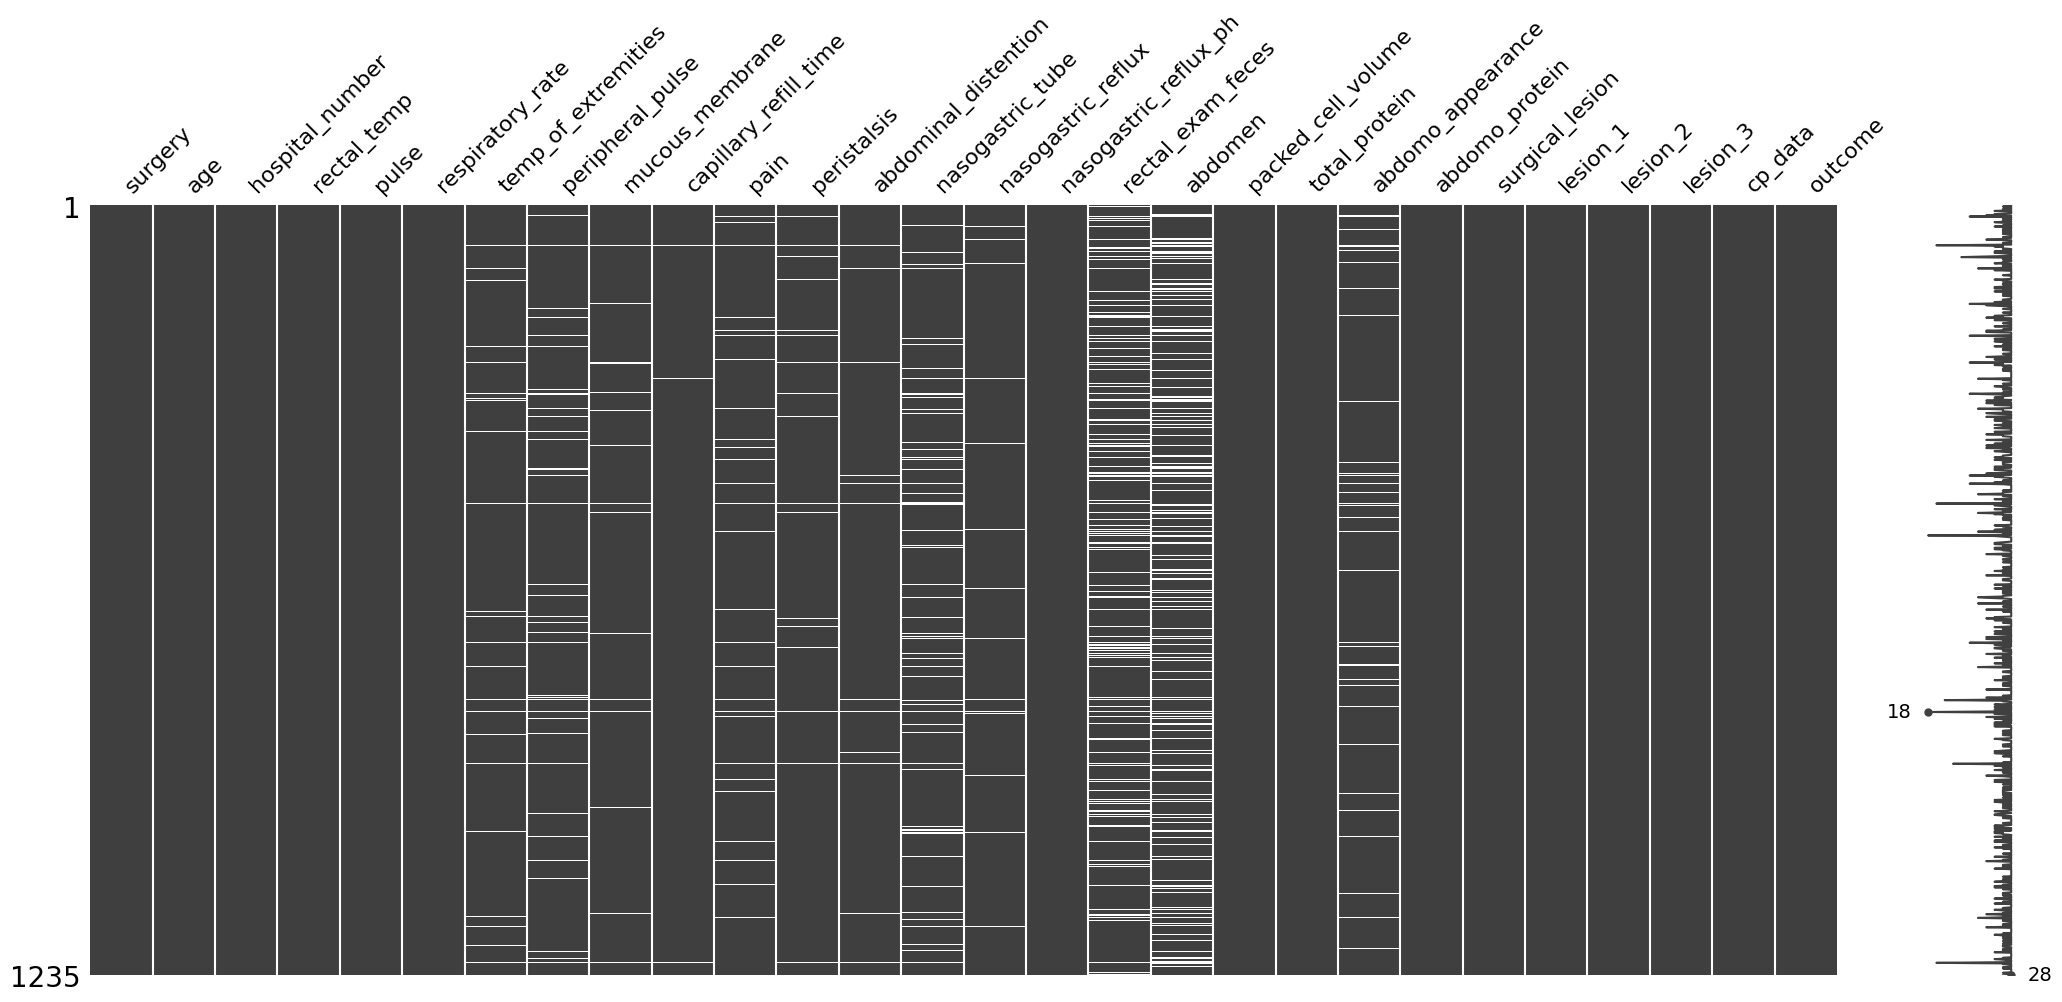

In [17]:
import missingno as msno
msno.matrix(train_horses)

<Axes: >

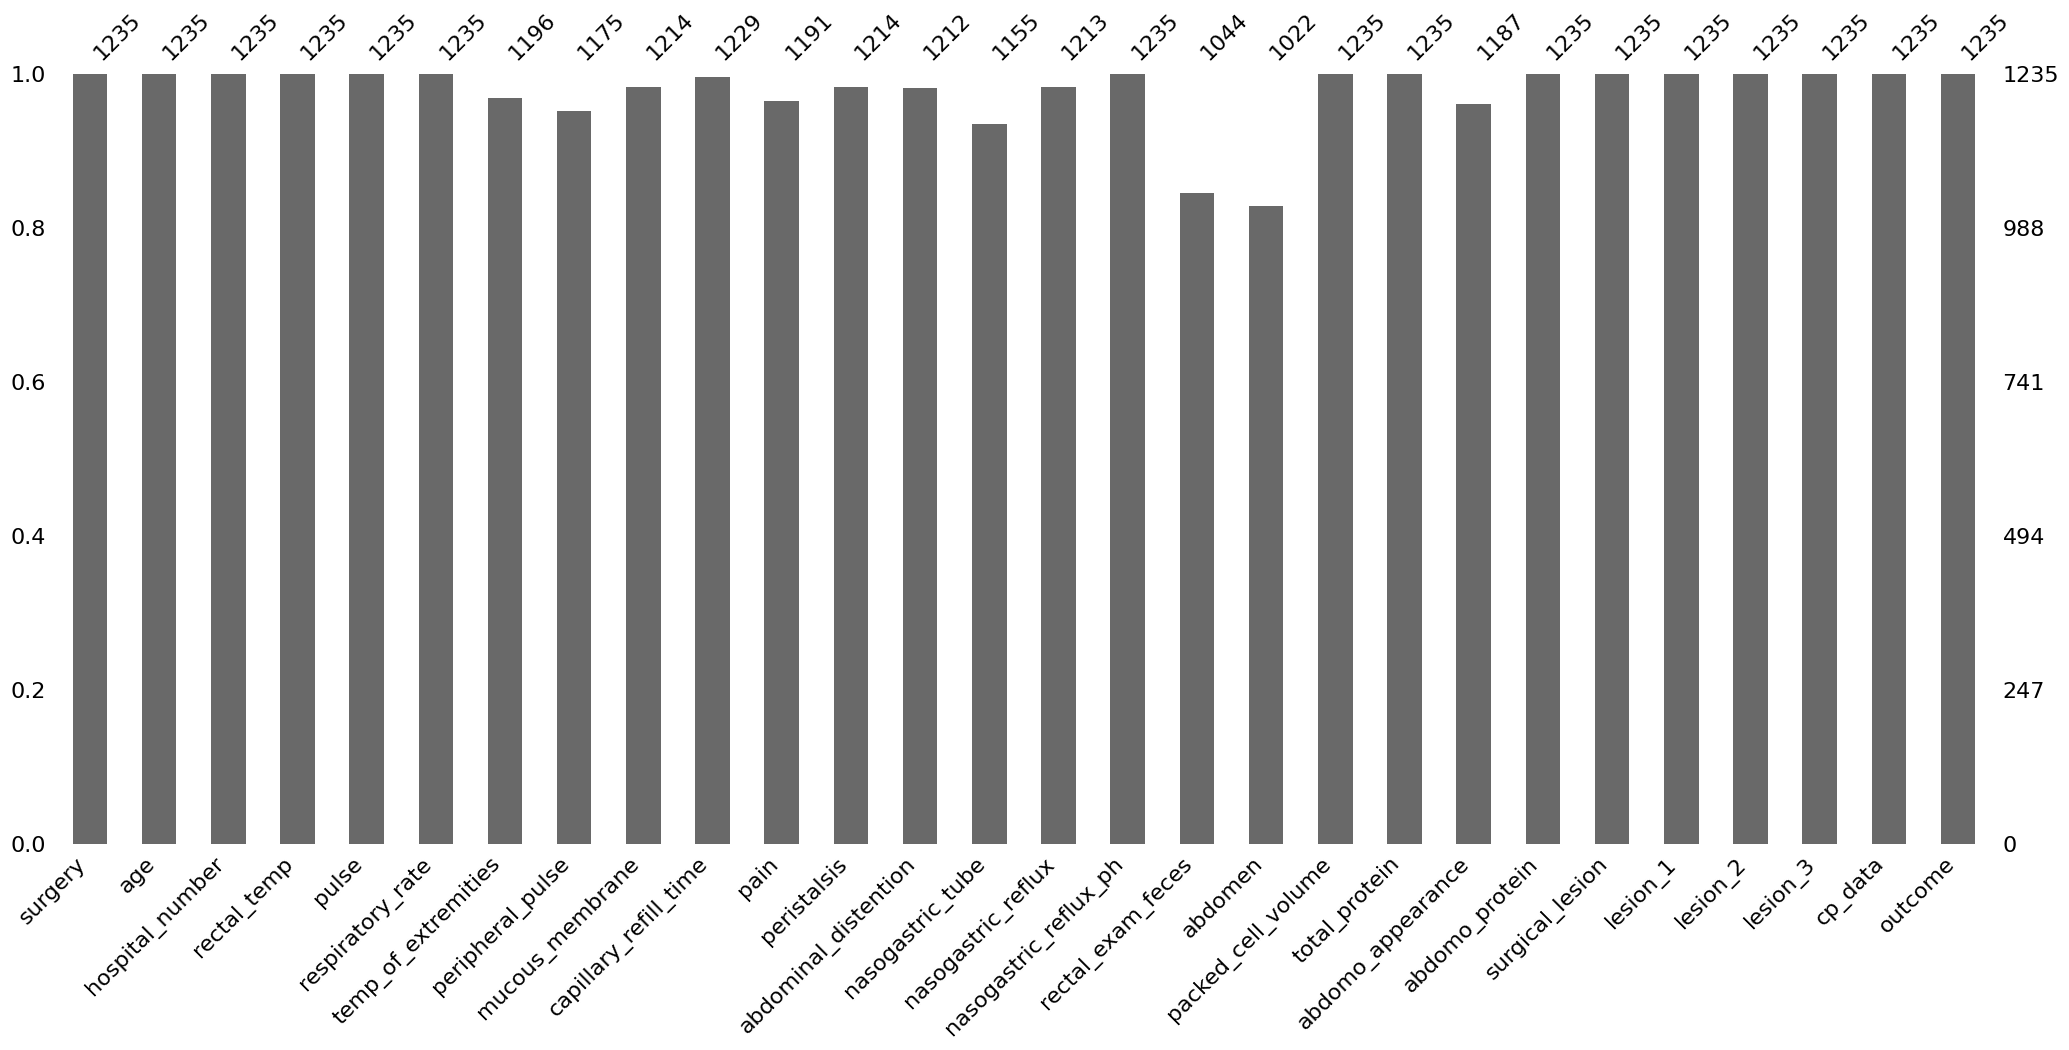

In [18]:
msno.bar(train_horses)

<Axes: >

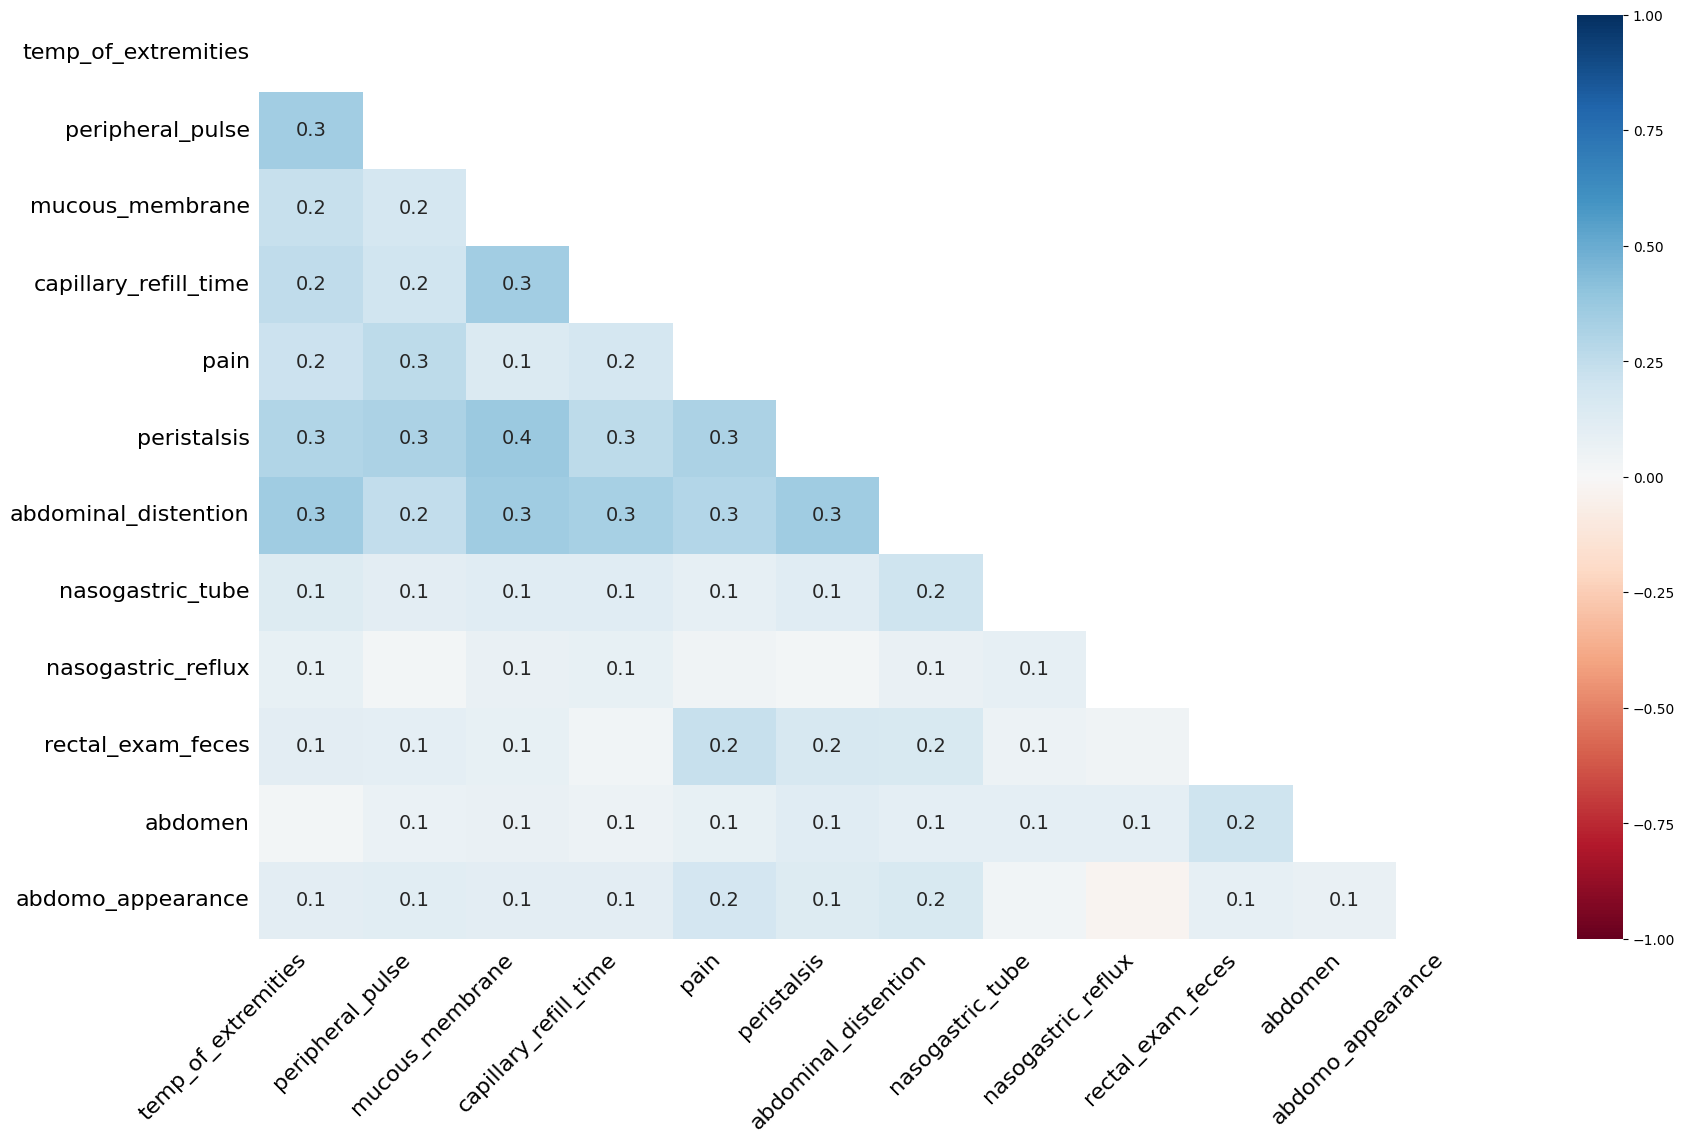

In [19]:
msno.heatmap(train_horses)

#### Quick Feature Engineering

In [20]:
train_horses['lesion']=train_horses['lesion_1']+train_horses['lesion_2']+train_horses['lesion_3']

In [21]:
test_horses['lesion']=test_horses['lesion_1']+test_horses['lesion_2']+test_horses['lesion_3']

In [22]:
train_horses['lesion'] = train_horses['lesion'].astype('str')
train_horses['lesion1'] = train_horses['lesion'].apply(lambda x: x+'0'*(4-len(x)) if len(x) <= 4 else x)
train_horses['lesion_site'] = train_horses['lesion1'].apply(lambda x: x[:2] if len(x) == 5 and x[0] == '1' else x[0])
train_horses['lesion_type'] = train_horses['lesion1'].apply(lambda x: x[2] if len(x) == 5 and x[0] == '1' else x[1])
train_horses['lesion_subtype'] = train_horses['lesion1'].apply(lambda x: x[3] if len(x) == 5 and x[0] == '1' else x[2])
train_horses['lesion_code'] = train_horses['lesion1'].apply(lambda x: x[-2:] if len(x) == 5 and x[0] != '1' else x[-1])
train_horses.lesion_type.replace({'7': '0'}, inplace=True)

In [23]:
test_horses['lesion'] = test_horses['lesion'].astype('str')
test_horses['lesion1'] = test_horses['lesion'].apply(lambda x: x+'0'*(4-len(x)) if len(x) <= 4 else x)
test_horses['lesion_site'] = test_horses['lesion1'].apply(lambda x: x[:2] if len(x) == 5 and x[0] == '1' else x[0])
test_horses['lesion_type'] = test_horses['lesion1'].apply(lambda x: x[2] if len(x) == 5 and x[0] == '1' else x[1])
test_horses['lesion_subtype'] = test_horses['lesion1'].apply(lambda x: x[3] if len(x) == 5 and x[0] == '1' else x[2])
test_horses['lesion_code'] = test_horses['lesion1'].apply(lambda x: x[-2:] if len(x) == 5 and x[0] != '1' else x[-1])
test_horses.lesion_type.replace({'7': '0'}, inplace=True)

In [24]:
train_horses = train_horses.drop(['lesion', 'lesion1', 'lesion_1', 'lesion_2', 'lesion_3'], axis=1)

In [25]:
test_horses = test_horses.drop(['lesion', 'lesion1', 'lesion_1', 'lesion_2', 'lesion_3'], axis=1)

### Treating Missing Data

#### Dropping Missing Data to check score

In [26]:
train_cleaned=train_horses.dropna()

In [27]:
X = train_cleaned.copy()
y = X.pop("outcome")
y, _ = y.factorize()

In [28]:
# Label encoding for categoricals
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()
    
# Label encoding for categoricals
for colname in X.select_dtypes("bool"):
    X[colname] = X[colname].astype(int)

In [29]:
score = score_dataset(X, y)
score

0.6657997399219766

#### label encoding before missing data imputation

In [30]:
X = train_horses.copy()
y = X.pop("outcome")
y, _ = y.factorize()

In [31]:
# Label encoding for categoricals
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()
    
# Label encoding for categoricals
for colname in X.select_dtypes("bool"):
    X[colname] = X[colname].astype(int)
    

#### score

In [32]:
score = score_dataset(X, y)
score

0.6947368421052632

### Treating Missing Data Before Encoding

In [33]:
# Separate columns into numeric and categorical
numeric_cols = []
categorical_cols = []

for column in train_horses.columns:
    if train_horses[column].dtype in ['int64', 'float64']:
        numeric_cols.append(column)
    else:
        categorical_cols.append(column)

# Create new DataFrames with the separated columns
numeric_horses = train_horses[numeric_cols]
categorical_horses = train_horses[categorical_cols]

# Display the resulting DataFrames
print("Numeric Columns:")
print(numeric_horses)

print("\nCategorical Columns:")
print(categorical_horses)

Numeric Columns:
      hospital_number  rectal_temp  pulse  respiratory_rate  \
0              530001         38.1  132.0              24.0   
1              533836         37.5   88.0              12.0   
2              529812         38.3  120.0              28.0   
3             5262541         37.1   72.0              30.0   
4             5299629         38.0   52.0              48.0   
...               ...          ...    ...               ...   
1230           535246         38.5  129.0              48.0   
1231           528570         37.5   60.0              50.0   
1232           529685         37.5   84.0              40.0   
1233           534784         38.1   70.0              16.0   
1234           528548         38.1   54.0              36.0   

      nasogastric_reflux_ph  packed_cell_volume  total_protein  abdomo_protein  
0                       6.5                57.0            8.5             3.4  
1                       2.0                33.0           64.0  

In [34]:
# Separate columns into numeric and categorical
test_numeric_cols = []
test_categorical_cols = []

for column in test_horses.columns:
    if test_horses[column].dtype in ['int64', 'float64']:
        test_numeric_cols.append(column)
    else:
        test_categorical_cols.append(column)

# Create new DataFrames with the separated columns
test_numeric_horses = test_horses[test_numeric_cols]
test_categorical_horses = test_horses[test_categorical_cols]

# Display the resulting DataFrames
print("Numeric Columns:")
print(test_numeric_horses)

print("\nCategorical Columns:")
print(test_categorical_horses)

Numeric Columns:
     hospital_number  rectal_temp  pulse  respiratory_rate  \
0             534053         38.6   40.0              20.0   
1             528469         38.2  112.0              48.0   
2             528178         37.7   66.0              12.0   
3             534784         37.1   88.0              20.0   
4             529840         38.3   50.0              12.0   
..               ...          ...    ...               ...   
819           529461         40.3  114.0              36.0   
820           535338         37.2  100.0              20.0   
821           529640         39.2  132.0              12.0   
822          5287179         38.3   54.0              66.0   
823           528461         38.1   66.0              12.0   

     nasogastric_reflux_ph  packed_cell_volume  total_protein  abdomo_protein  
0                      7.0                42.0            7.5             2.3  
1                      3.5                44.0            6.0             2.6 

In [35]:
cat_cols=categorical_horses.columns

In [36]:
test_cat_cols=test_categorical_horses.columns

In [37]:
for cols in cat_cols:
    train_horses[cols].fillna('Unknown', inplace=True)

In [38]:
for test_cols in test_cat_cols:
    test_horses[cols].fillna('Unknown', inplace=True)

#### Visualizing the data

##### numeric variables

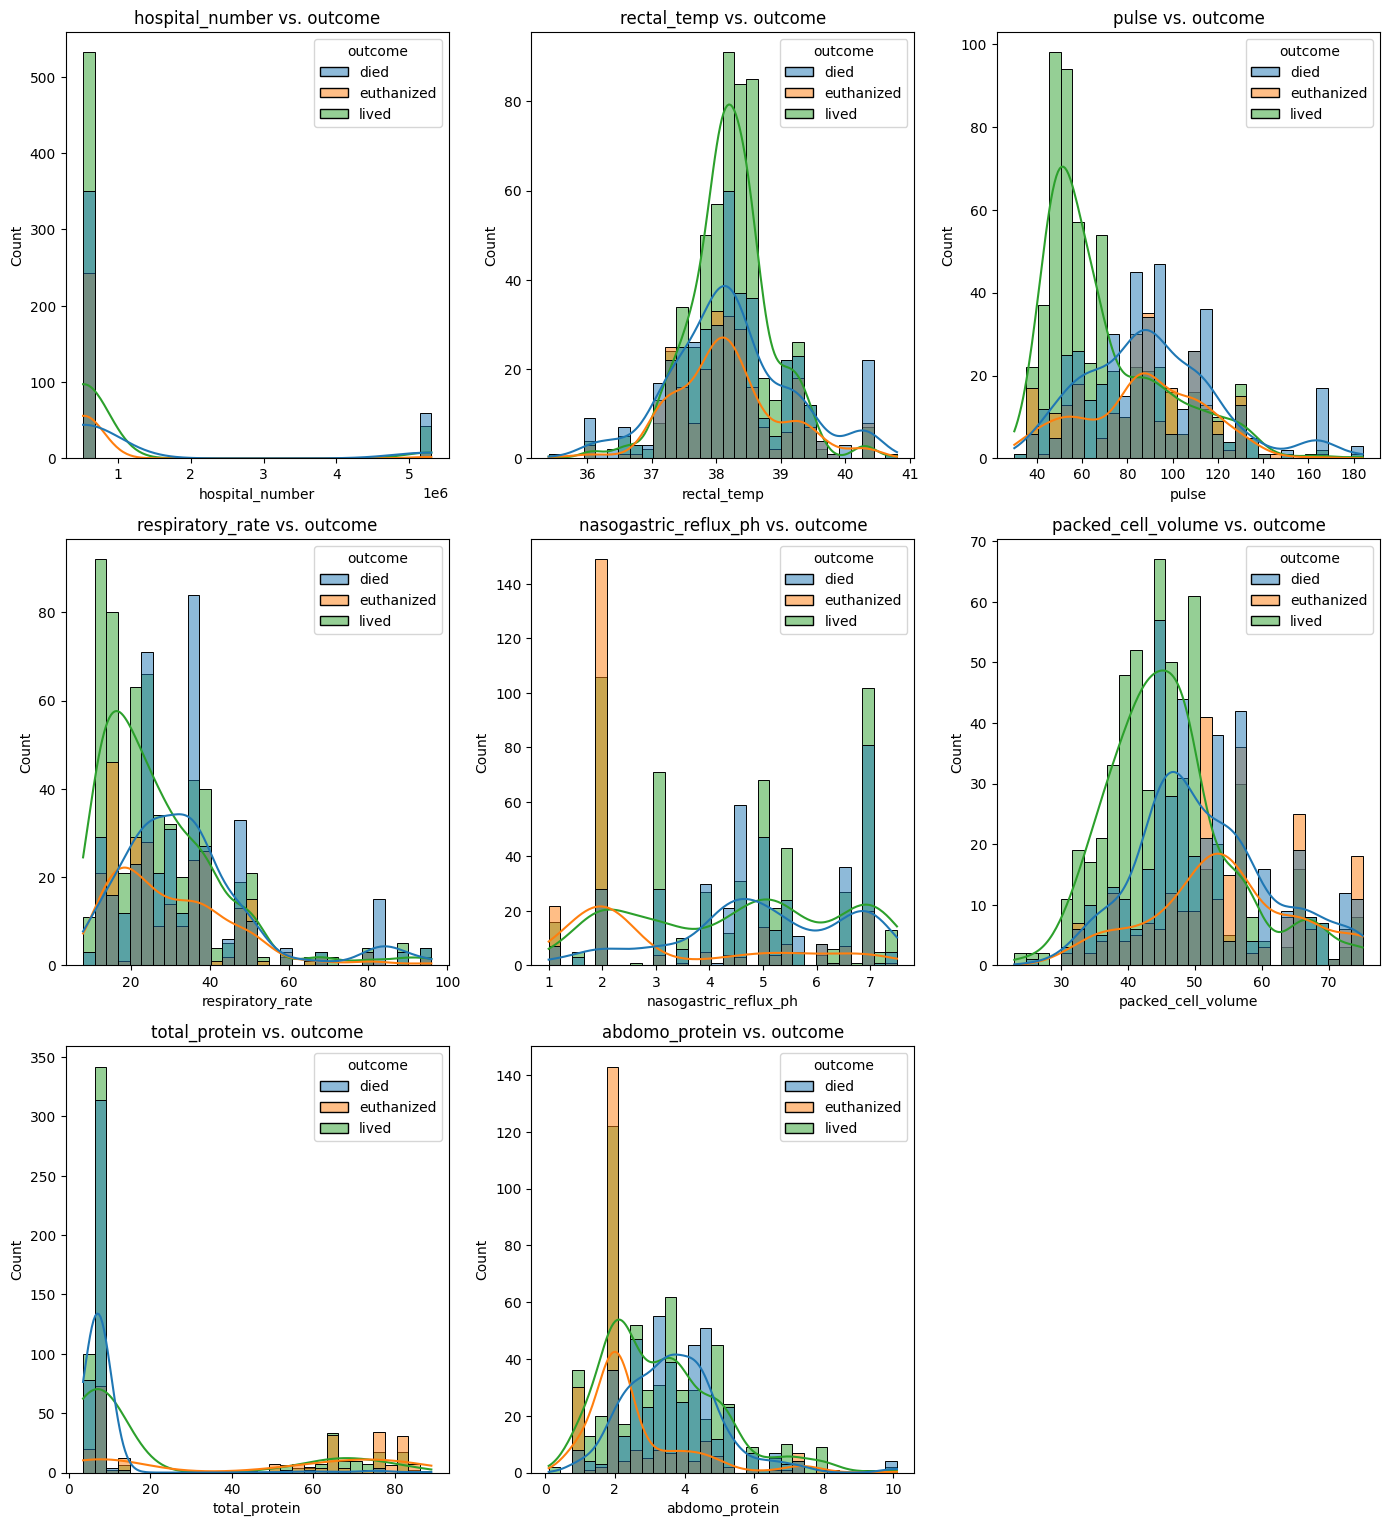

In [39]:
# Define the number of rows and columns for the subplot grid
num_rows =4  # Adjust as needed
num_cols = len(numeric_cols) // num_rows + 1

# Create subplots for each numeric variable and plot them
plt.figure(figsize=(14, len(numeric_cols) * 2.5))

for i, col in enumerate(numeric_cols):
    plt.subplot(num_rows, num_cols, i+1)
    sns.histplot(data=train_horses, x=col, hue="outcome", bins=30, kde=True)
    plt.title(f'{col} vs. outcome')
    
plt.tight_layout()
plt.show()


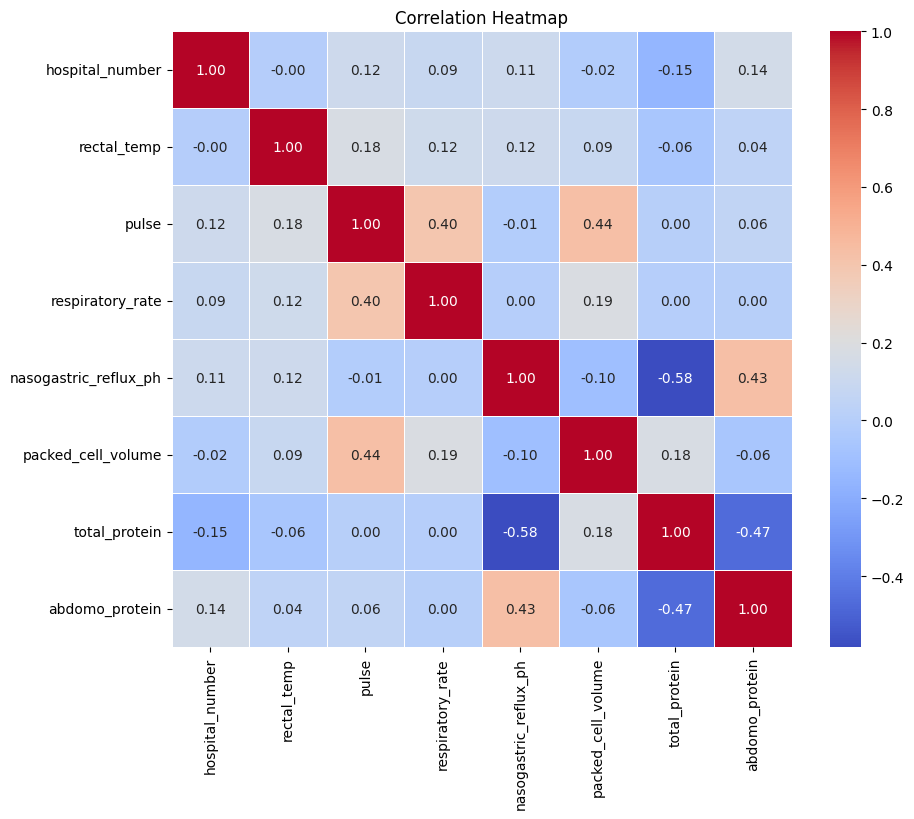

In [40]:
# Calculate the correlation matrix
correlation_matrix = train_horses[numeric_cols].corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()


##### Categorical Variables

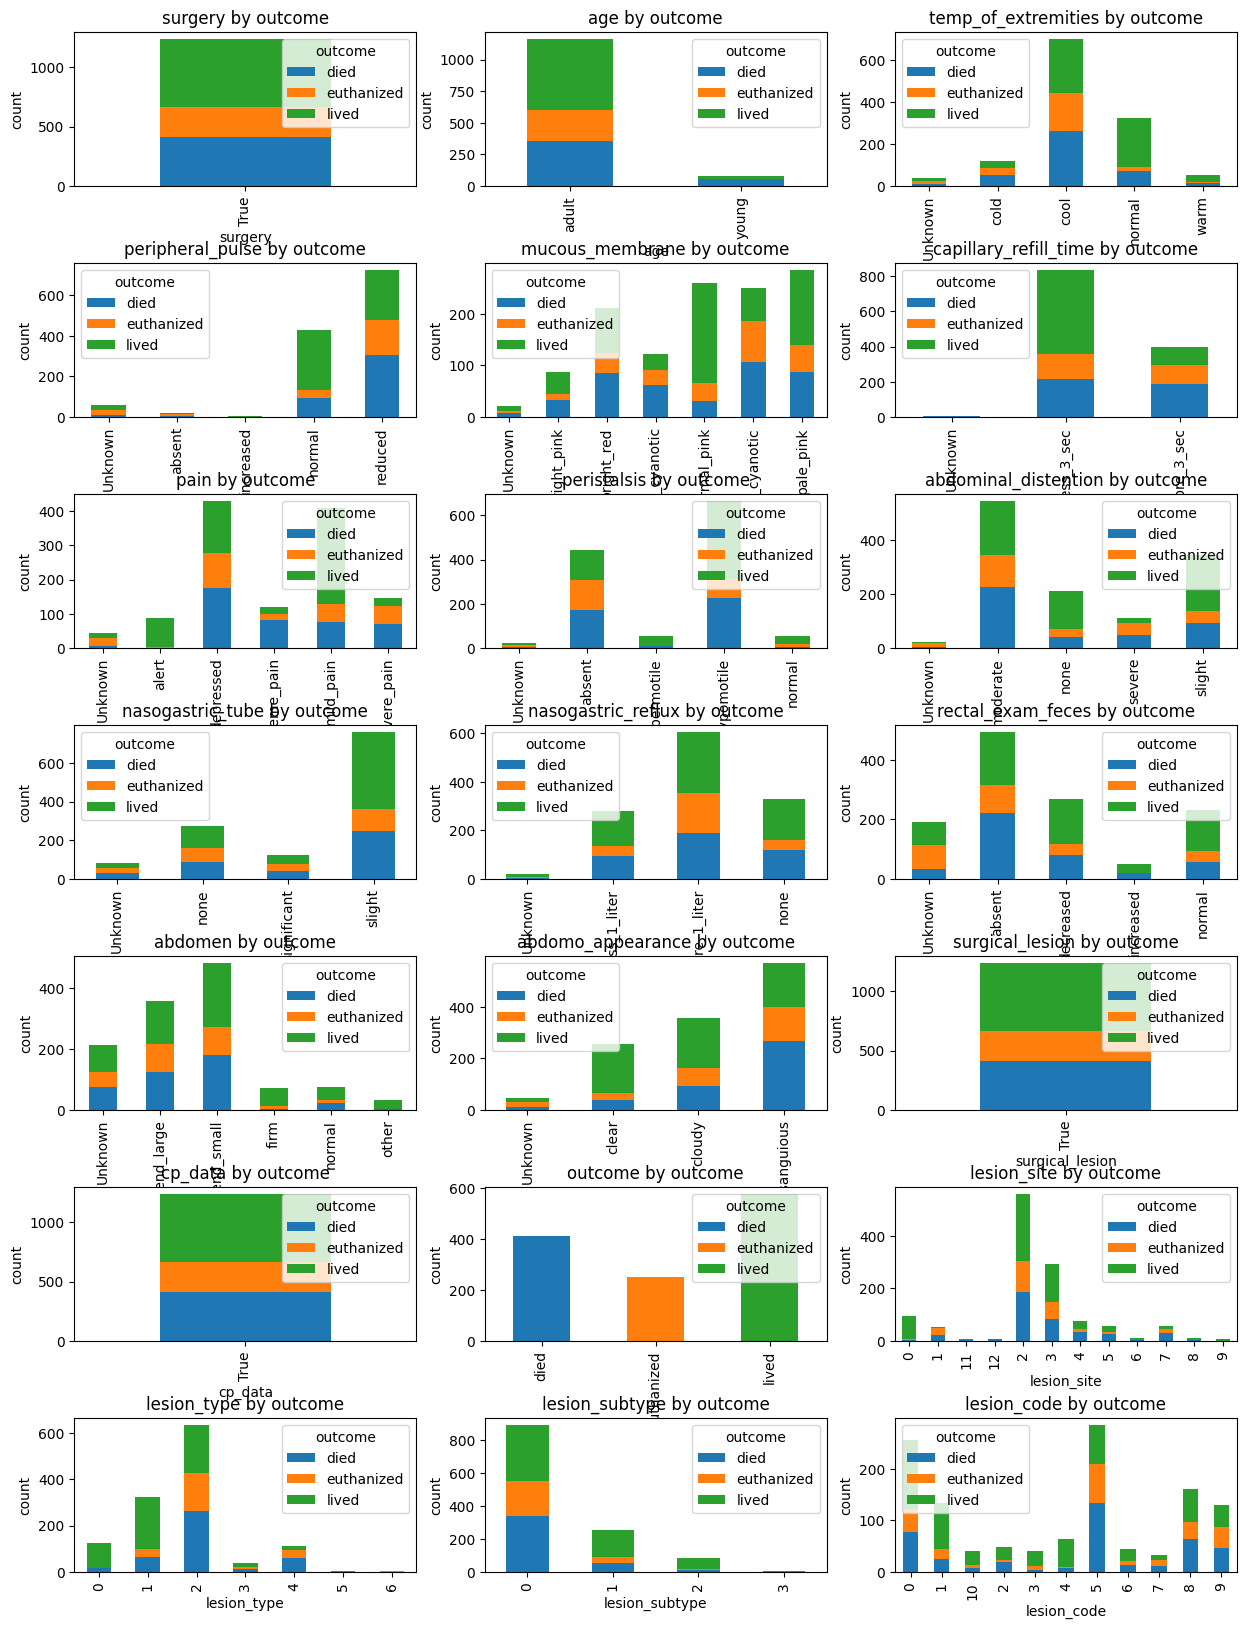

In [41]:
# Example data (replace with your own dataset)
data = train_horses  # Load your dataset here

# Create a subplot grid
num_cols = 3  # Number of columns in the grid
num_rows = (len(categorical_cols) + num_cols - 1) // num_cols  # Calculate the number of rows

# Set up the figure and axes
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15,20))
fig.subplots_adjust(hspace=0.5)  # Adjust vertical spacing

# Loop through categorical variables and create subplots
for i, cat_var in enumerate(categorical_cols):
    row_idx = i // num_cols
    col_idx = i % num_cols

    # Create a contingency table
    contingency_table = pd.crosstab(data[cat_var], data['outcome'])
    
    # Create a stacked bar chart on the current subplot
    contingency_table.plot(kind='bar', stacked=True, ax=axes[row_idx, col_idx])
    axes[row_idx, col_idx].set_xlabel(cat_var)
    axes[row_idx, col_idx].set_ylabel('count')
    axes[row_idx, col_idx].set_title(f'{cat_var} by outcome')

# Remove any empty subplots
for i in range(len(categorical_cols), num_rows * num_cols):
    fig.delaxes(axes.flatten()[i])

plt.show()


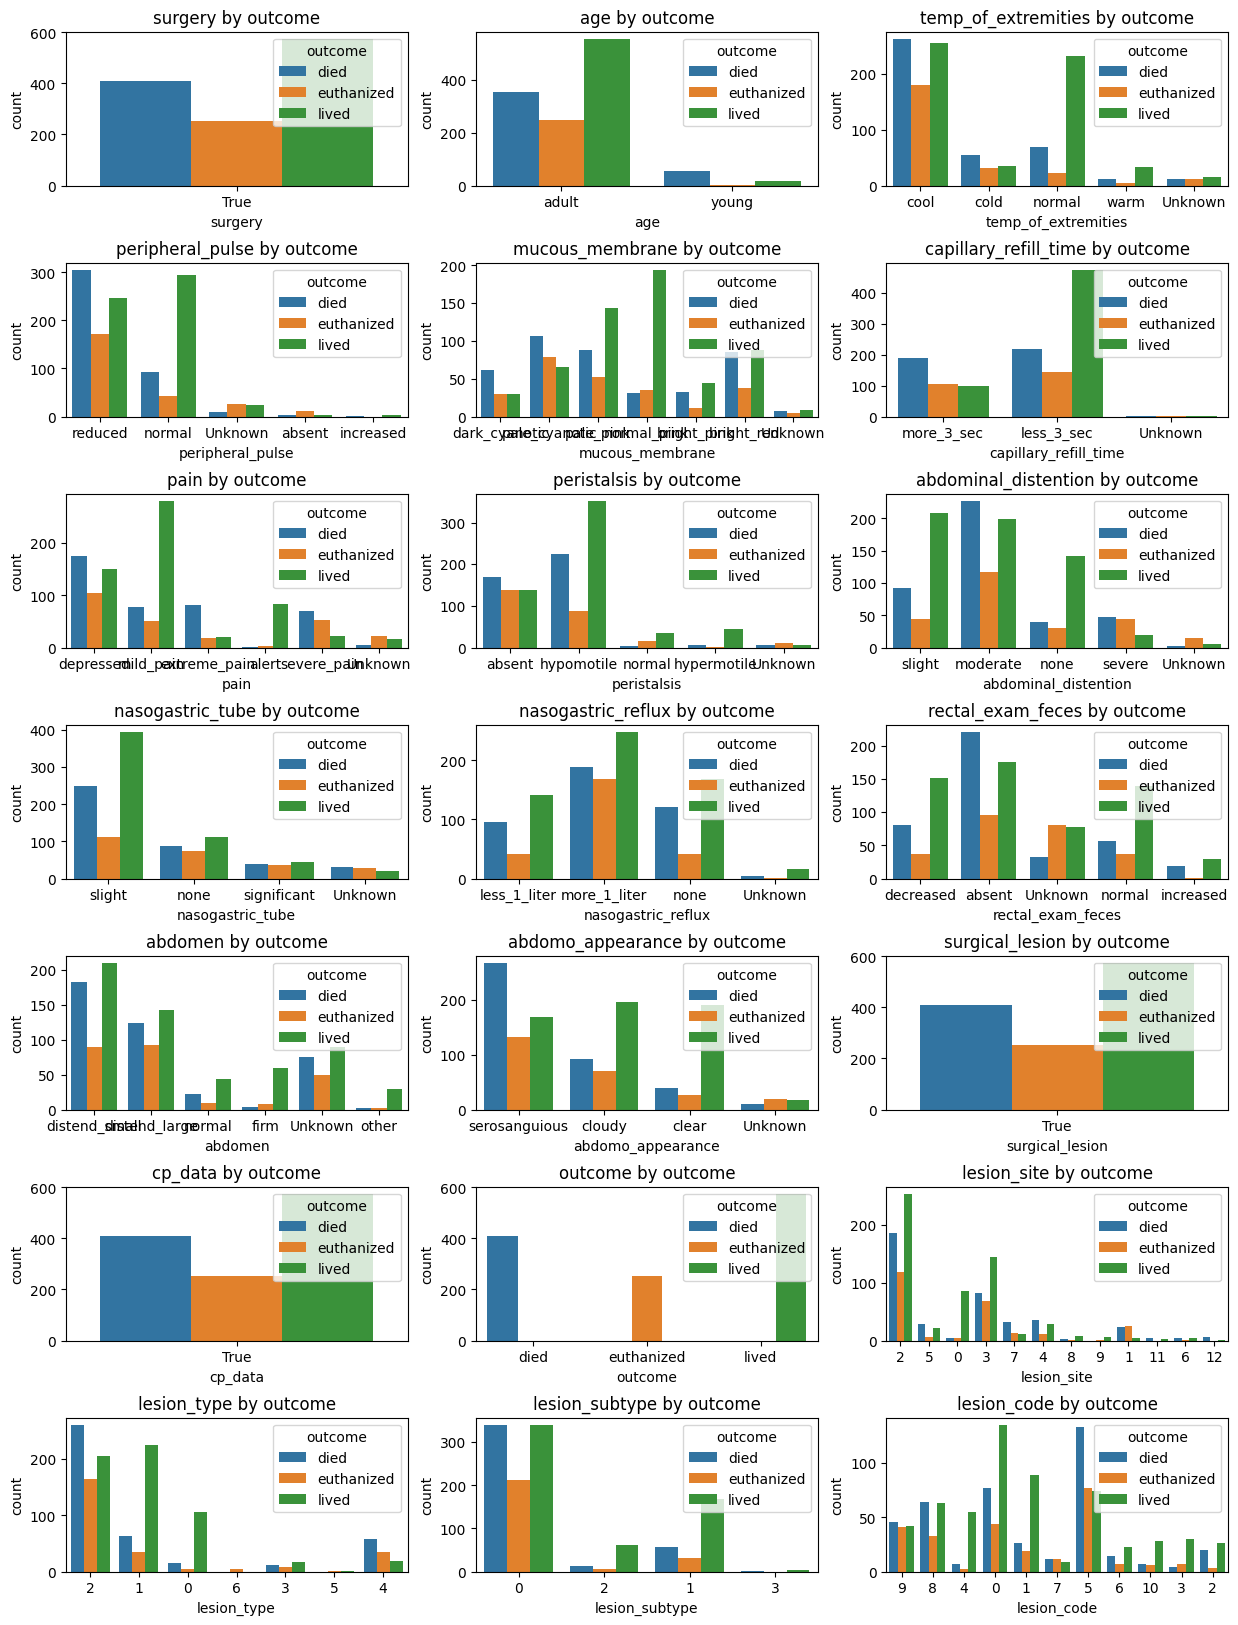

In [42]:
# Example data (replace with your own dataset)
data = train_horses  # Load your dataset here

# Create a subplot grid
num_cols = 3  # Number of columns in the grid
num_rows = (len(categorical_cols) + num_cols - 1) // num_cols  # Calculate the number of rows

# Set up the figure and axes
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15,20))
fig.subplots_adjust(hspace=0.5)  # Adjust vertical spacing

# Loop through categorical variables and create subplots
for i, cat_var in enumerate(categorical_cols):
    row_idx = i // num_cols
    col_idx = i % num_cols

    sns.countplot(x=cat_var, hue='outcome', data=data, ax=axes[row_idx, col_idx])
    axes[row_idx, col_idx].set_xlabel(cat_var)
    axes[row_idx, col_idx].set_ylabel('count')
    axes[row_idx, col_idx].set_title(f'{cat_var} by outcome')

# Remove any empty subplots
for i in range(len(categorical_cols), num_rows * num_cols):
    fig.delaxes(axes.flatten()[i])

plt.show()


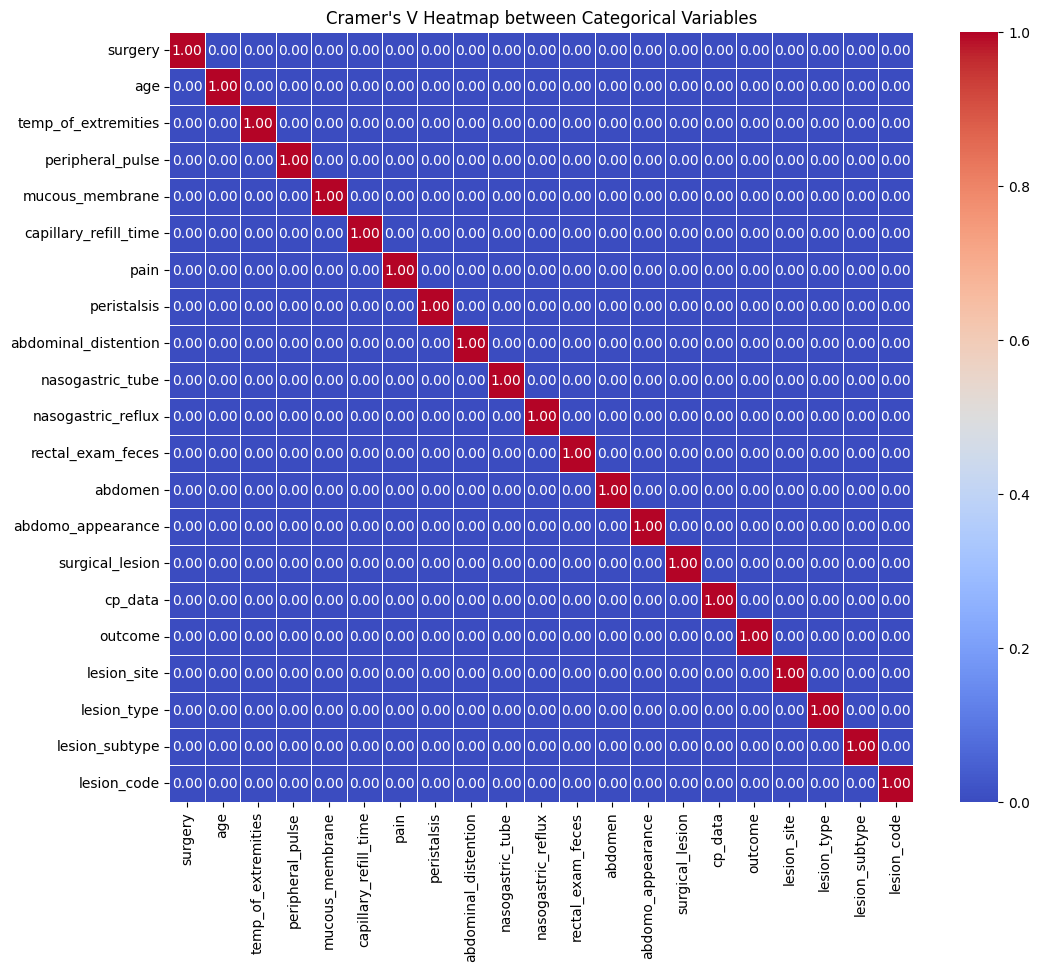

In [43]:
from scipy.stats import chi2_contingency


# Calculate Cramer's V for each pair of categorical variables
correlation_matrix = pd.DataFrame(index=categorical_cols, columns=categorical_cols)

for var1 in categorical_cols:
    for var2 in categorical_cols:
        if var1 == var2:
            correlation_matrix.loc[var1, var2] = 1.0
        else:
            contingency_table = pd.crosstab(data[var1], data[var2])
            chi2, _, _, _ = chi2_contingency(contingency_table)
            n = contingency_table.sum().sum()
            phi2 = chi2 / n
            r, _ = contingency_table.shape
            phi2_corr = max(0, phi2 - ((r - 1) * (n - 1)) / (n - r))

            # Calculate Cramer's V
            if (r - 1) == 0 or (1 - 1) == 0:
                correlation_matrix.loc[var1, var2] = 0.0
            else:
                r_corr = r - ((r - 1) ** 2) / (n - 1)
                correlation_matrix.loc[var1, var2] = np.sqrt(phi2_corr / min((r_corr - 1), (1 - 1)))

# Convert elements in the correlation matrix to numeric
correlation_matrix = correlation_matrix.apply(pd.to_numeric, errors='coerce')

# Create a heatmap of the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Cramer\'s V Heatmap between Categorical Variables')
plt.show()


##### Cat Against Num

In [44]:
from scipy import stats


# Create a grid of subplots
num_rows = len(categorical_cols)
num_cols = len(numeric_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(90, 100), sharex='col')
fig.subplots_adjust(hspace=0.5)  # Adjust vertical spacing

# Loop through categorical and numeric variables
for i, cat_var in enumerate(categorical_cols):
    for j, num_var in enumerate(numeric_cols):
        # Visualization: Box plot
        sns.boxplot(x=cat_var, y=num_var, data=data, ax=axes[i, j])
        axes[i, j].set_title(f'{cat_var} vs. {num_var} (Box Plot)')
        axes[i, j].tick_params(axis='x', rotation=45)  # Rotate x-axis labels

        # Statistical test: T-test or ANOVA (example using t-test)
        groups = [data[num_var][data[cat_var] == category] for category in data[cat_var].unique()]
        if len(groups) < 2:
            p_value = 1.0  # Default p-value if there's only one group
        else:
            f_stat, p_value = stats.f_oneway(*groups)
        axes[i, j].set_xlabel(f'p-value = {p_value:.4f}')

# Remove empty subplots if needed
for i in range(len(categorical_cols), num_rows):
    for j in range(num_cols):
        fig.delaxes(axes[i, j])

plt.show()


### Label Encoding after treating missing data

In [45]:
# Label encoding for categoricals
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()
    
# Label encoding for categoricals
for colname in X.select_dtypes("bool"):
    X[colname] = X[colname].astype(int)
    

# All discrete features should now have integer dtypes (double-check this before using MI!)
discrete_features = X.dtypes == int

In [46]:
X_test = test_horses.copy()

In [47]:
# Label encoding for categoricals
for colname in X_test.select_dtypes("object"):
    X_test[colname], _ = X_test[colname].factorize()
    
# Label encoding for categoricals
for colname in X_test.select_dtypes("bool"):
    X_test[colname] = X_test[colname].astype(int)

<Axes: >

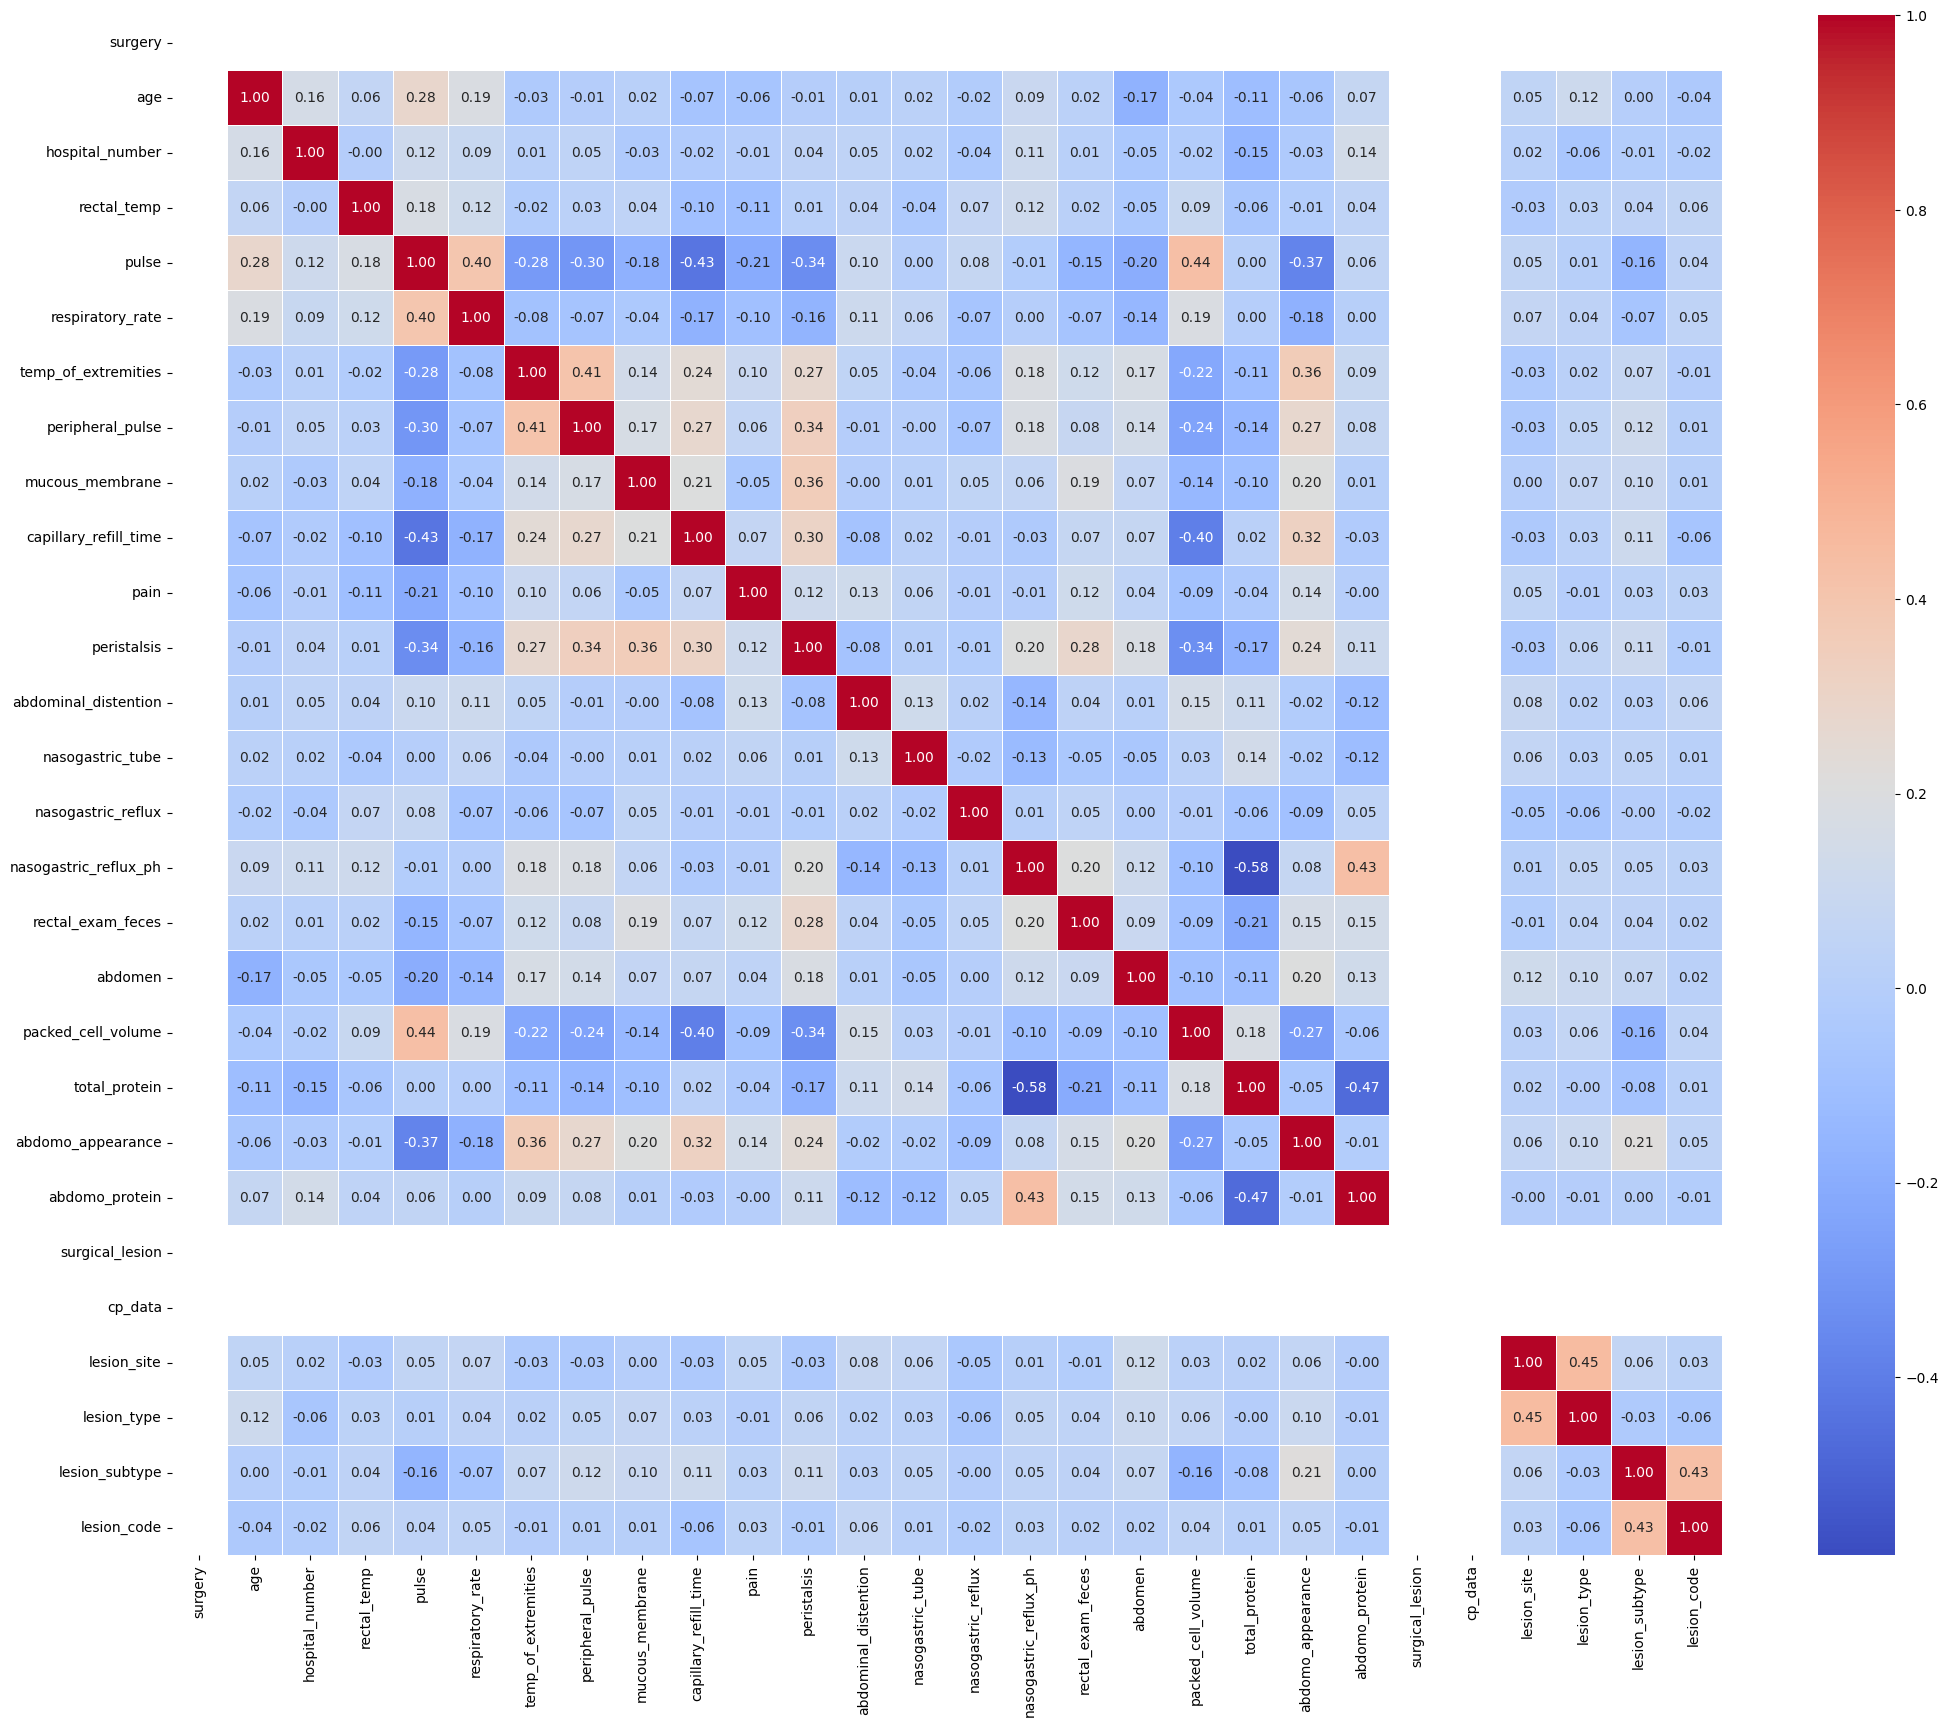

In [48]:
# Create a heatmap of the correlation matrix
plt.figure(figsize=(25, 20))
correlation=X.corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)

In [49]:
cat_columns=['surgery',
 'age',
 'temp_of_extremities',
 'peripheral_pulse',
 'mucous_membrane',
 'capillary_refill_time',
 'pain',
 'peristalsis',
 'abdominal_distention',
 'nasogastric_tube',
 'nasogastric_reflux',
 'rectal_exam_feces',
 'abdomen',
 'abdomo_appearance',
 'surgical_lesion',
 'cp_data',
 'lesion_site',
 'lesion_type',
 'lesion_subtype']

<Axes: >

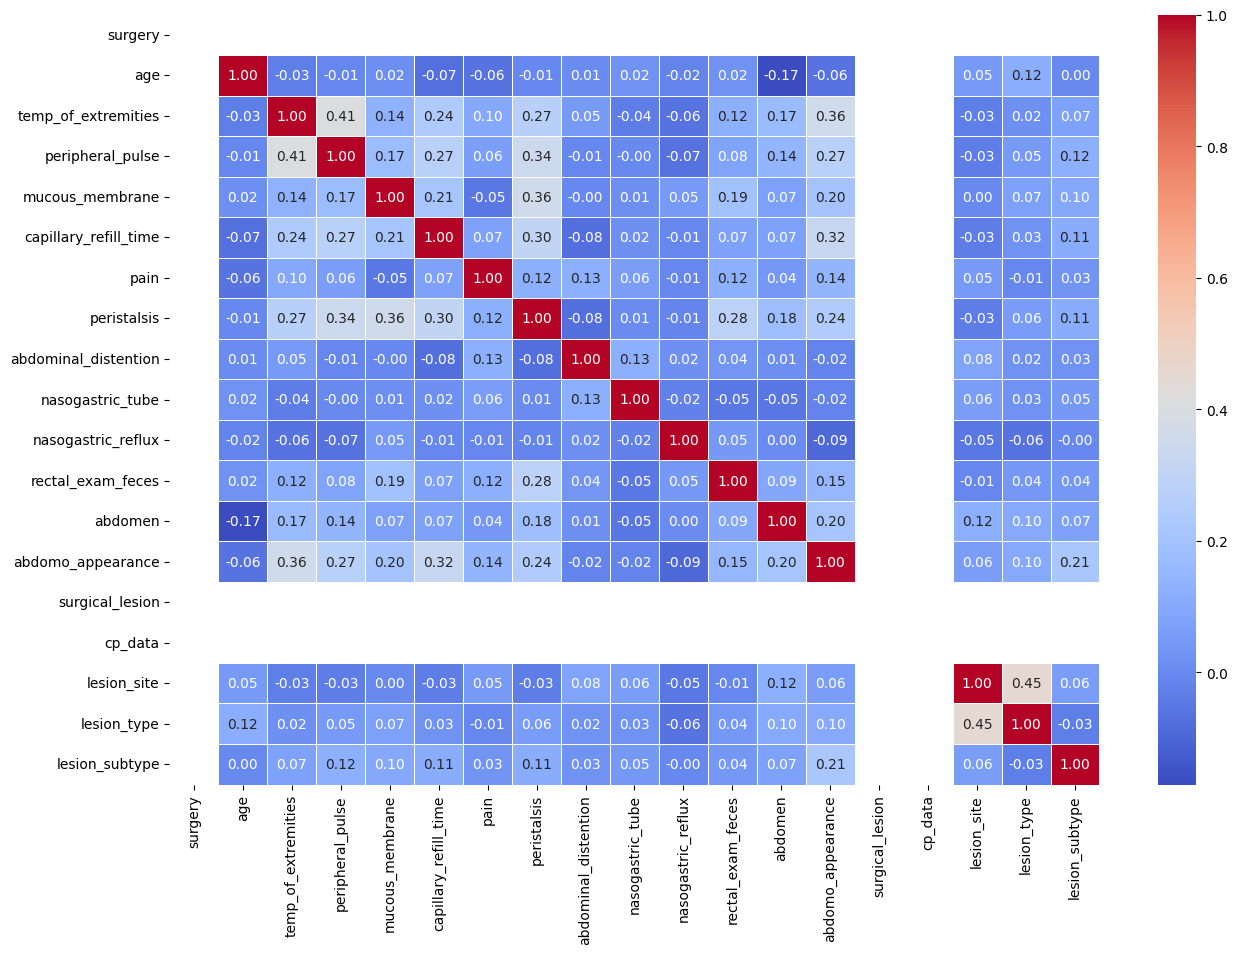

In [50]:
# Create a heatmap of the correlation matrix
plt.figure(figsize=(15, 10))
correlation=X[cat_columns].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)

In [51]:
X = train_horses.copy()
y = X.pop("outcome")
y, _ = y.factorize()
X['peripheral_temp']=X['peripheral_pulse']+"_"+X['temp_of_extremities']
X['lesion_tsite']=X['lesion_type']+"_"+X['lesion_site']
X.drop(columns=['peripheral_pulse', 'temp_of_extremities', 
                'lesion_type', 'lesion_site'], inplace=True)

In [52]:
X_test = test_horses.copy()
X_test['peripheral_temp']=X_test['peripheral_pulse']+"_"+X_test['temp_of_extremities']
X_test['lesion_tsite']=X_test['lesion_type']+"_"+X_test['lesion_site']
X_test.drop(columns=['peripheral_pulse', 'temp_of_extremities', 
                'lesion_type', 'lesion_site'], inplace=True)

In [53]:
from sklearn.decomposition import PCA
pca = PCA(n_components=1)  # Reduce to one principal component
X['PCA_Component'] = pca.fit_transform(X[['packed_cell_volume', 'pulse']])
X['PCA_Component1'] = pca.fit_transform(X[['respiratory_rate', 'pulse']])
X['PCA_Component2'] = pca.fit_transform(X[['total_protein', 'nasogastric_reflux_ph']])
X['PCA_Component3'] = pca.fit_transform(X[['abdomo_protein', 'nasogastric_reflux_ph']])
X['PCA_Component4'] = pca.fit_transform(X[['total_protein', 'abdomo_protein']])

In [54]:
from sklearn.decomposition import PCA
pca = PCA(n_components=1)  # Reduce to one principal component
X_test['PCA_Component'] = pca.fit_transform(X_test[['packed_cell_volume', 'pulse']])
X_test['PCA_Component1'] = pca.fit_transform(X_test[['respiratory_rate', 'pulse']])
X_test['PCA_Component2'] = pca.fit_transform(X_test[['total_protein', 'nasogastric_reflux_ph']])
X_test['PCA_Component3'] = pca.fit_transform(X_test[['abdomo_protein', 'nasogastric_reflux_ph']])
X_test['PCA_Component4'] = pca.fit_transform(X_test[['total_protein', 'abdomo_protein']])

In [55]:
# Label encoding for categoricals
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()
    
# Label encoding for categoricals
for colname in X.select_dtypes("bool"):
    X[colname] = X[colname].astype(int)

In [56]:
# Label encoding for categoricals
for colname in X_test.select_dtypes("object"):
    X_test[colname], _ = X_test[colname].factorize()
    
# Label encoding for categoricals
for colname in X_test.select_dtypes("bool"):
    X_test[colname] = X_test[colname].astype(int)

### Label Encoding Result

In [57]:
score_base = score_dataset(X, y)
score_base

0.6939271255060728

### Treating Outliers

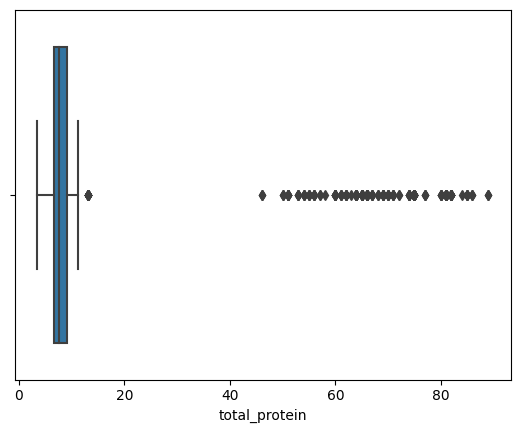

In [58]:
# box plot to identify outliers in a numerical column 'feature'
sns.boxplot(x=X['total_protein'])
plt.show()

In [59]:
X[X['total_protein']>=40]

surgery  age  hospital_number  rectal_temp  pulse  respiratory_rate  \
1           1    0           533836         37.5   88.0              12.0   
6           1    0           534787         38.3   36.0              16.0   
16          1    0           534885         37.8   60.0              16.0   
20          1    0           533692         37.8   48.0              16.0   
21          1    0           535208         37.5   96.0              24.0   
...       ...  ...              ...          ...    ...               ...   
1227        1    0           534293         38.5   48.0              16.0   
1228        1    0           534963         38.3   48.0              20.0   
1229        1    0           535338         38.0  136.0              20.0   
1230        1    0           535246         38.5  129.0              48.0   
1233        1    0           534784         38.1   70.0              16.0   

      mucous_membrane  capillary_refill_time  pain  peristalsis  ...  cp_data  \
1                   1                      0     1            0  ...        1   
6                   3                      1     4            2  ...        1   
16                  3                      1     0            2  ...        1   
20                  3                      1     2            1  ...        1   
21                  0                      0     4            0  ...        1   
...               ...                    ...   ...          ...  ...      ...   
1227                3                      1     3            1  ...        1   
1228                4                      0     0            0  ...        1   
1229                5                      1     0            1  ...        1   
1230                2                      0     0            0  ...        1   
1233                5                      1     1            1  ...        1   

      lesion_subtype  lesion_code  peripheral_temp  lesion_tsite  \
1                  0            1                1             0   
6                  2            4                0             3   
16                 0            1                5             0   
20                 0            6                0             4   
21                 0            1                0             0   
...              ...          ...              ...           ...   
1227               0            3                3             2   
1228               2            4                3             3   
1229               0            1                0             0   
1230               0            7                0             0   
1233               0            0                8             0   

      PCA_Component  PCA_Component1  PCA_Component2  PCA_Component3  \
1          5.426869        2.903593       42.674726       -2.702608   
6        -44.059305      -45.773845       53.664801       -3.241925   
16       -21.459053      -22.778720       53.664801       -3.241925   
20       -30.510341      -34.276283       31.684651       -2.702608   
21        19.014849       14.004630       43.673824       -2.702608   
...             ...             ...             ...             ...   
1227     -32.586191      -34.276283       39.698668       -3.662977   
1228     -32.586191      -33.130951       43.673824       -2.702608   
1229      58.411810       51.184506       43.546411       -0.176301   
1230      49.960454       52.494916       44.672921       -2.702608   
1233      -7.977075      -13.197418       52.665703       -2.702608   

      PCA_Component4  
1          42.631428  
6          53.655152  
16         53.655152  
20         31.635757  
21         43.631034  
...              ...  
1227       39.660661  
1228       43.631034  
1229       43.631034  
1230       44.630641  
1233       52.627492  

[280 rows x 31 columns]

#### Dealing with the outliers

In [60]:
# Define a condition to select rows for transformation (e.g., rows with values >= 40)
condition = X['total_protein']>=40

# Convert the selected rows to a float data type (if not already)
X.loc[condition, 'total_protein'] = X.loc[condition, 'total_protein'].astype(float)

# Divide the selected rows' values by 10
X.loc[condition, 'total_protein'] = X.loc[condition, 'total_protein'] / 10

# Round the selected rows' values to one decimal place (optional)
X.loc[condition, 'total_protein'] = X.loc[condition, 'total_protein'].round(1)


In [61]:
# Define a condition to select rows for transformation (e.g., rows with values >= 40)
test_condition = X_test['total_protein']>=40

# Convert the selected rows to a float data type (if not already)
X_test.loc[test_condition, 'total_protein'] = X_test.loc[test_condition, 'total_protein'].astype(float)

# Divide the selected rows' values by 10
X_test.loc[test_condition, 'total_protein'] = X_test.loc[test_condition, 'total_protein'] / 10

# Round the selected rows' values to one decimal place (optional)
X_test.loc[test_condition, 'total_protein'] = X_test.loc[test_condition, 'total_protein'].round(1)


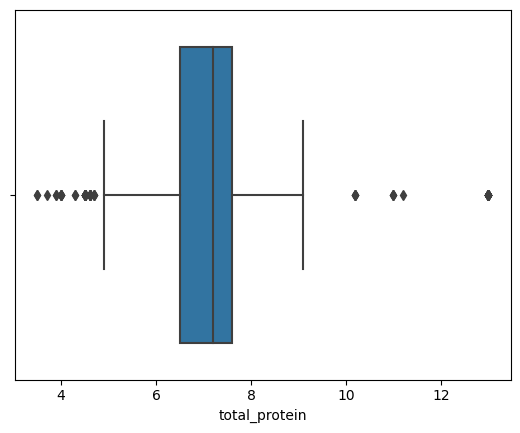

In [62]:
# Example box plot to identify outliers in a numerical column 'feature'
sns.boxplot(x=X['total_protein'])
plt.show()

In [63]:
score_base = score_dataset(X, y)
score_base

0.7020242914979757

### Getting Mutual Information

In [64]:
# All discrete features should now have integer dtypes (double-check this before using MI!)
discrete_features = X.dtypes == int

In [65]:
from sklearn.feature_selection import mutual_info_classif

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores[::3]  # show a few features with their MI scores

hospital_number     0.426632
PCA_Component2      0.193213
PCA_Component3      0.163666
pain                0.145150
peripheral_temp     0.104692
mucous_membrane     0.069711
total_protein       0.053241
respiratory_rate    0.040395
rectal_temp         0.023507
nasogastric_tube    0.019240
surgery             0.000000
Name: MI Scores, dtype: float64

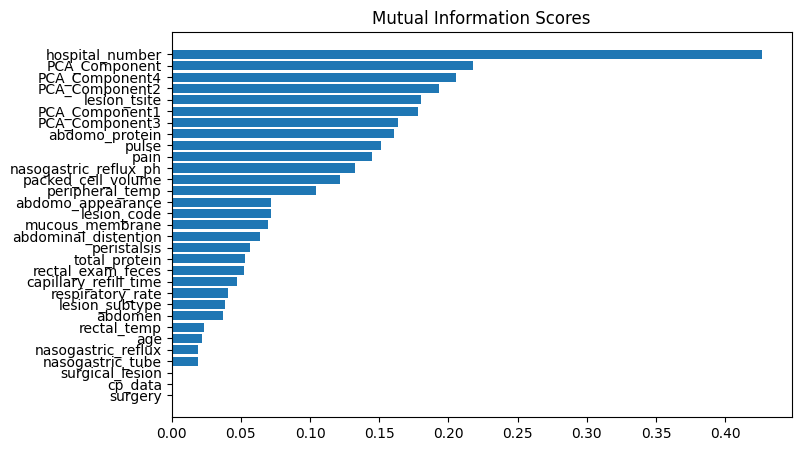

In [66]:
import matplotlib.pyplot as plt
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

### Feature Selection

In [67]:
def f_importance_plot(f_imp):
    fig = plt.figure(figsize=(12, 0.20*len(f_imp)))
    plt.title(f'Feature importances', size=16, y=1.05, 
              fontweight='bold')
    a = sns.barplot(data=f_imp, x='imp', y='feature', linestyle="-", 
                    linewidth=0.5, edgecolor="black",palette='GnBu')
    plt.xlabel('')
    plt.xticks([])
    plt.ylabel('')
    plt.yticks(size=11)
    
    for j in ['right', 'top', 'bottom']:
        a.spines[j].set_visible(False)
    for j in ['left']:
        a.spines[j].set_linewidth(0.5)
    plt.tight_layout()
    plt.show()

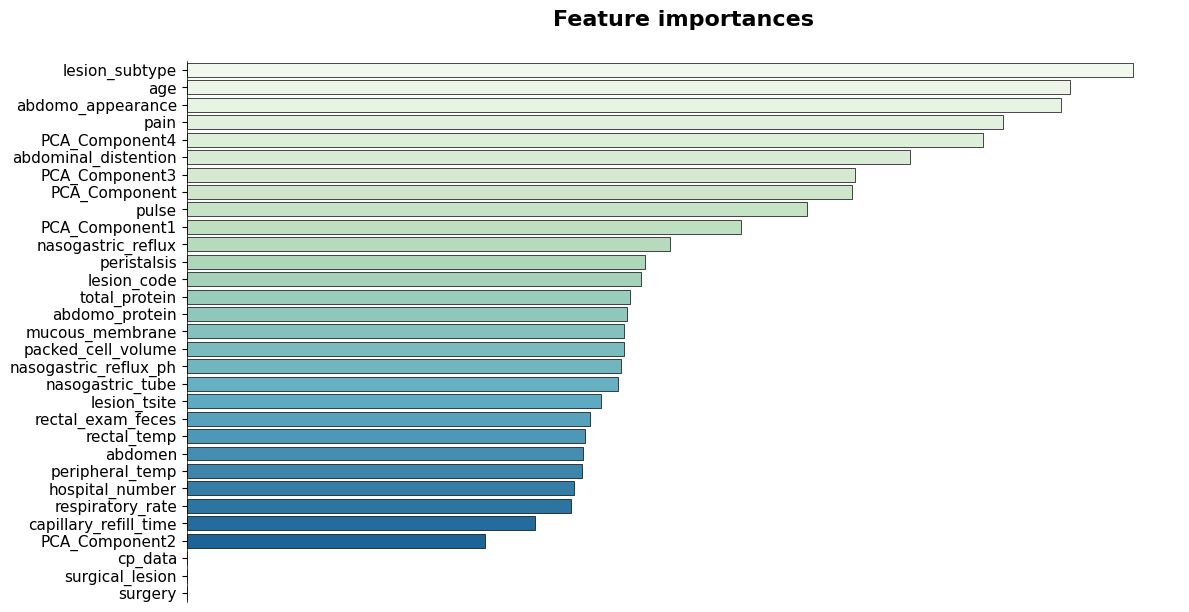

In [68]:
xg = XGBClassifier(n_estimators=1000,
                     max_depth=10,
                     random_state=42)
xg.fit(X, y)

f_imp_df = pd.DataFrame({'feature': X.columns, 'imp': xg.feature_importances_})
f_imp_df.sort_values(by='imp',ascending=False,inplace=True)
f_importance_plot(f_imp_df)

### Modelling

In [69]:
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

In [70]:
# Split the data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [71]:
# Initialize and train XGBoost Classifier
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)

# Initialize and train CatBoost Classifier
catboost_model = CatBoostClassifier()
catboost_model.fit(X_train, y_train)

# Initialize and train LightGBM Classifier
lgb_model = LGBMClassifier()
lgb_model.fit(X_train, y_train)

Learning rate set to 0.079078
0:	learn: 1.0636981	total: 64.5ms	remaining: 1m 4s
1:	learn: 1.0290995	total: 69ms	remaining: 34.4s
2:	learn: 1.0014250	total: 73.1ms	remaining: 24.3s
3:	learn: 0.9766244	total: 77.7ms	remaining: 19.3s
4:	learn: 0.9562994	total: 81.8ms	remaining: 16.3s
5:	learn: 0.9312920	total: 85.9ms	remaining: 14.2s
6:	learn: 0.9128681	total: 90.1ms	remaining: 12.8s
7:	learn: 0.8976243	total: 94.4ms	remaining: 11.7s
8:	learn: 0.8806962	total: 98.5ms	remaining: 10.8s
9:	learn: 0.8658284	total: 103ms	remaining: 10.2s
10:	learn: 0.8508379	total: 107ms	remaining: 9.61s
11:	learn: 0.8380891	total: 111ms	remaining: 9.16s
12:	learn: 0.8254467	total: 115ms	remaining: 8.77s
13:	learn: 0.8120031	total: 120ms	remaining: 8.44s
14:	learn: 0.8006453	total: 124ms	remaining: 8.15s
15:	learn: 0.7902047	total: 128ms	remaining: 7.88s
16:	learn: 0.7811932	total: 132ms	remaining: 7.64s
17:	learn: 0.7731782	total: 136ms	remaining: 7.43s
18:	learn: 0.7654781	total: 140ms	remaining: 7.22s
19:	

LGBMClassifier()

In [72]:
# Make predictions
xgb_preds = xgb_model.predict(X_val)
catboost_preds = catboost_model.predict(X_val)
lgb_preds = lgb_model.predict(X_val)

In [73]:
# Concatenate the arrays
catboost_preds = np.concatenate(catboost_preds, axis=0)

In [74]:
# Calculate the micro-average F-1 score for each algorithm
xgb_f1 = f1_score(y_val, xgb_preds, average='micro')
ctb_f1 = f1_score(y_val, catboost_preds, average='micro')
lgb_f1 = f1_score(y_val, lgb_preds, average='micro')

In [75]:
# Calculate the micro-average F-1 score for each algorithm
xgb_f1
ctb_f1 
lgb_f1

0.7206477732793523

In [76]:
# Select the algorithm with the highest micro-average F-1 score
best_model = max([xgb_model, catboost_model, lgb_model], key=lambda model: model.score(X_val, y_val))

In [77]:
new_preds=best_model.predict(X_test)

In [78]:
sample_submission=pd.read_csv("/kaggle/input/playground-series-s3e22/sample_submission.csv")

In [79]:
sample_submission['outcome'] = new_preds
sample_submission

id  outcome
0    1235        2
1    1236        2
2    1237        2
3    1238        1
4    1239        2
..    ...      ...
819  2054        2
820  2055        1
821  2056        2
822  2057        0
823  2058        2

[824 rows x 2 columns]

In [80]:
final_submission=sample_submission

In [81]:
# Create a mapping dictionary
outcome_mapping = {0: 'died', 1: 'euthanized', 2: 'lived'}

# Map the values in the "outcome" column using the dictionary
final_submission['outcome'] = final_submission['outcome'].map(outcome_mapping)
final_submission

id     outcome
0    1235       lived
1    1236       lived
2    1237       lived
3    1238  euthanized
4    1239       lived
..    ...         ...
819  2054       lived
820  2055  euthanized
821  2056       lived
822  2057        died
823  2058       lived

[824 rows x 2 columns]

In [82]:
final_submission.to_csv('final_submission.csv')